The goal of the homework is to study, based on actual production data, the notion of "peak oil" introduced in lecture 1

#### Administrativia
Groups composition to be provided no later than Wednesday, Sep. 25, 8 PM (by email)\
GROUPS SHALL DIFFER IN MEMBERSHIP FROM HOMEWORK #1\
Homework to be turned in Thursday, Oct. 3, 10 PM (deposit .ipynb file in Moodle / General Informations, only 1 submission per group)\
Please indicate here the names of the group's members: Walid Ajbar, Yiwen Mai, Alen Rostomyan

#### Data set
One CSV file, Oil_production.csv taken from https://www.energyinst.org/statistical-review/resources-and-data-downloads \
Description: crude oil production in million tonnes by country/region (col.A) and year\
NOTE: this is a good example of using "real world" imperfect data sets which have not been prepared for machine processing\
IMPORTANT: Your program shall take as input this csv file, without manual cleaning/preparation

#### Data preparation
Study the data set and identify what cleanup/preparation steps are needed \
Remove all "Total" lines and remove USSR (it appears after the 1991 breakup as its member countries)

In [1]:
import pandas as pd 
df = pd.read_csv('Oil_production.csv', skiprows=1,encoding='latin1', delimiter=';')
print(f'original csv file: {df.head()}')

# drop first two rows
df = df.drop(df.index[:2])
print(f'first two rows dropped: {df.head()}')

# Keep all rows"Total" lines, lines withut country names,and remove USSR
df_filtered = df[
    (~df.iloc[:,0].str.contains('Total', case=False, na=False)) &
    (~df.iloc[:,0].str.contains('USSR', case=False, na=False)) &
    (df.iloc[:,0].notna())
]

df = df.reset_index(drop=True)
df_filtered.to_csv('Oil_production_cleaned.csv', index=False, float_format='%.1f', sep=';', decimal='.')

original csv file:   Unnamed: 0 Unnamed: 1 Unnamed: 2 Unnamed: 3 Unnamed: 4 Unnamed: 5  \
0    Country       1965       1966       1967       1968       1969   
1        NaN        NaN        NaN        NaN        NaN        NaN   
2     Canada       43,9       48,2       52,7       57,1       62,2   
3     Mexico       18,1       18,5       20,5       21,9         23   
4         US      427,7      454,5      484,2      502,9      511,4   

  Unnamed: 6 Unnamed: 7 Unnamed: 8 Unnamed: 9  ... Unnamed: 53 Unnamed: 54  \
0       1970       1971       1972       1973  ...        2017        2018   
1        NaN        NaN        NaN        NaN  ...         NaN         NaN   
2       70,1       75,2       86,7      100,3  ...       236,6       257,7   
3       24,2       24,1       25,1       25,9  ...       109,5       102,3   
4      533,5      525,9      527,9      514,7  ...       574,2       669,6   

  Unnamed: 55 Unnamed: 56 Unnamed: 57 Unnamed: 58 Unnamed: 59  \
0        2019       

#### Data processing
Write a function which takes as input :
1. time series (floats)
2.   a threshold (float)

and returns true if the last two data points of the time series are more than threshold % lower than the maximum value in the series

In [2]:
# Series is a number indicating a row in csv
def has_peaked(series, threshold):
    df = pd.read_csv('Oil_production_cleaned.csv', delimiter=';', header=0)
    row = df.iloc[series,1:-3] # Choose all columns except the country column in given rows

    numeric_row = row.apply(lambda x: float(str(x).replace(',', '.')) if isinstance(x, str) else x)

    max_value = numeric_row.max()

    sec_last = numeric_row.iloc[-5] 
    last = numeric_row.iloc[-4] # Two last columns in every chosen row
    
    if ((max_value - last)/ max_value > threshold and (max_value - sec_last)/ max_value > threshold):
        return True # Production peaked
    else:
        return False # Production not peaked
# Returns bool

# Check
has_peaked(3, 0.5)


False

##### First graph
Plot on Y axis the percentage (0 to 1) of all oil-producing countries whose recent production (last 2 years) is more than threshold % lower than their peak as a function of threshold, with threshold ranging from 0 to 100 (X axis)\
How many countries have not peaked yet?

Number of countries that have not peaked yet: 49


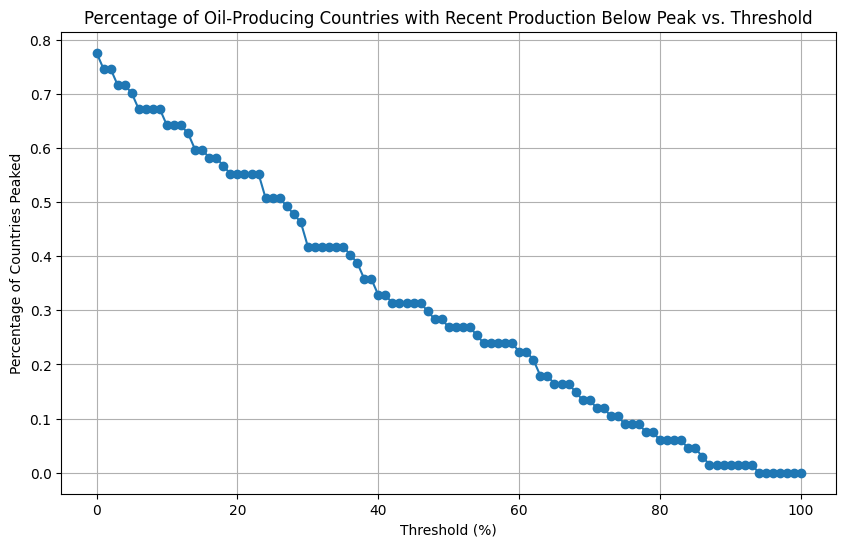

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Load cleaned CSV file
df = pd.read_csv('Oil_production_cleaned.csv', delimiter=';', header=0)

# Function to determine if production has peaked
def has_peaked(series, threshold):
    # Choose all columns except the country column in given row
    row = df.iloc[series, 1:-3]  
    # Convert to numeric, handling commas as decimal points and ignoring invalid entries
    numeric_row = row.apply(lambda x: float(str(x).replace(',', '.')) if str(x).replace(',', '.').replace('.', '').isdigit() else np.nan)
    # Drop any NaN values
    numeric_row = numeric_row.dropna()

    # If there's insufficient data, we assume the country hasn't peaked
    if len(numeric_row) < 5:
        return False
    
    # Calculate max, second last, and last values
    max_value = numeric_row.max()
    sec_last = numeric_row.iloc[-2] if len(numeric_row) >= 2 else np.nan
    last = numeric_row.iloc[-1] if len(numeric_row) >= 1 else np.nan

    # Ensure sec_last and last are not NaN before comparison
    if np.isnan(max_value) or np.isnan(sec_last) or np.isnan(last):
        return False

    # Check if production has peaked based on the threshold
    if ((max_value - last) / max_value > threshold) and ((max_value - sec_last) / max_value > threshold):
        return True
    else:
        return False

# Check how many countries have not peaked yet
not_peaked_count = 0
total_countries = len(df)

for i in range(total_countries):
    if not has_peaked(i, 0.5):  # Assuming threshold is 0.5 (50%)
        not_peaked_count += 1

print(f'Number of countries that have not peaked yet: {not_peaked_count}')

# Plotting the percentage of countries whose recent production is more than threshold % lower than peak
thresholds = np.linspace(0, 1, 101)  # Thresholds from 0 to 1 (0% to 100%)
percentages = []

for threshold in thresholds:
    peaked_count = sum([has_peaked(i, threshold) for i in range(total_countries)])
    percentage = peaked_count / total_countries
    percentages.append(percentage)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(thresholds * 100, percentages, marker='o')
plt.xlabel('Threshold (%)')
plt.ylabel('Percentage of Countries Peaked')
plt.title('Percentage of Oil-Producing Countries with Recent Production Below Peak vs. Threshold')
plt.grid(True)
plt.show()


#### Second graph
Plot a stacked vertical bar graph with each country on the X axis (sorted by decreasing value of the country's maximum production). Each bar displays both the 2023  production and the maximum production (in a lighter color) of the country\
Bonus points if the bar's color encodes the oil-producing region the country belongs to.